# Defining the NAO index

This notebook finds a robust metric for the NAOi considering fluctuations in each season.

In [12]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

import cosima_cookbook as cc

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [13]:
import dask
import distributed
from dask.distributed import Client
with dask.config.set({"logging.distributed": "error"}):
    client = distributed.Client()

In [14]:
start_time, end_time = '1958-01-01', '2018-12-31'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
neofs = 3
neigs = 3
npcs = 3

In [15]:
model_out = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')

def regridder(da_in, label):
    if(label == 'ocean'):     ## Use when there is an atmosphere variable that needs to be converted to ocean grid
        return regridder_ocean_to_ocean(da_in)
    elif(label == 'atmos'):   ## Use when there is an ocean variable that needs to be converted to atmosphere grid
        return regridder_atmos_to_ocean(da_in)
    else:
        print('Error: Select between ocean and atmos grids.')
        
def regridder_atmos_to_ocean(da_in):
    grid_in = {'lon': da_in.lon.values, 'lat': da_in.lat.values}
    grid_out = {'lon': model_out.xt_ocean.values, 'lat': model_out.yt_ocean.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)
    
    regridded_da = regridded_da.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
    regridded_da = regridded_da.assign_coords({"geolon_t": model_out.geolon_t, "geolat_t": model_out.geolat_t})

    return regridded_da

def regridder_ocean_to_ocean(da_in):
    grid_in = {'lon': da_in.longitude.values, 'lat': da_in.latitude.values}
    grid_out = {'lon': model_out.geolon_t.values, 'lat': model_out.geolat_t.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)

    regridded_da = regridded_da.rename({"y": "yt_ocean", "x": "xt_ocean"})
    regridded_da = regridded_da.assign_coords({"xt_ocean": model_out.xt_ocean, "yt_ocean": model_out.yt_ocean})
    regridded_da = regridded_da.rename({"lon": "geolon_t", "lat": "geolat_t"})

    return regridded_da

## NAO index based on DJF data only

In [16]:
SLP_total = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/SLP_allseasons.nc')
SLP_total = SLP_total.SLP.sel(time = slice(start_time, end_time))
SLP_total['time'] = SLP_total['time'].values.astype('datetime64[M]') + np.timedelta64(14, 'D')
SLP_total = regridder(SLP_total, 'atmos')
SLP_NA = SLP_total.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))

In [17]:
# Compute anomalies
SLP_NA_DJF = SLP_NA.where(SLP_NA.time.dt.month.isin([12, 1, 2]), drop = True)
SLP_NA_mean = SLP_NA_DJF.mean('time')
SLP_NA_amly = SLP_NA_DJF - SLP_NA_mean

In [18]:
# Solve for EOF.
coslat = np.cos(np.deg2rad(SLP_NA.yt_ocean.values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver_DJF_SLP = Eof(SLP_NA_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_DJF_SLP = solver_DJF_SLP.eofsAsCovariance(neofs = neofs)

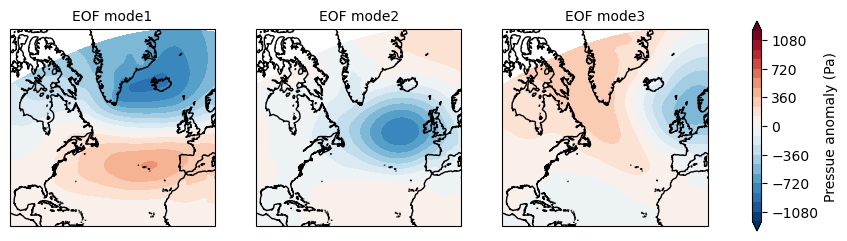

In [19]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_DJF_SLP[0], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_DJF_SLP[1], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_DJF_SLP[2], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressue anomaly (Pa)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

In [20]:
print('Percentage of EOF explained by first ' + str(3) + ' modes:' + str(
    100 * np.round(solver_DJF_SLP.varianceFraction(neigs = 3).values, 4)))

Percentage of EOF explained by first 3 modes:[41.77 22.18 12.36]


## Deseasonalising data and then calculating NAO index for all months

Does it even make sense to detrend it for an interannual forcing? I don't think so, and that's why I have moved straight to deseasonalising it.

In [21]:
SLP_climatology = SLP_NA.groupby('time.month').mean()
SLP_climatology

<xarray.DataArray (month: 12, yt_ocean: 400, xt_ocean: 440)> Size: 8MB
array([[[101178.79 , 101178.875, 101179.12 , ..., 101152.82 ,
         101154.99 , 101152.734],
        [101185.13 , 101185.31 , 101185.73 , ..., 101175.4  ,
         101176.86 , 101173.695],
        [101192.59 , 101192.87 , 101193.375, ..., 101193.26 ,
         101194.02 , 101190.86 ],
        ...,
        [101426.62 , 101421.5  , 101416.445, ..., 100307.47 ,
         100308.64 , 100309.82 ],
        [101425.6  , 101420.52 , 101415.516, ..., 100314.266,
         100315.53 , 100316.81 ],
        [101424.58 , 101419.54 , 101414.58 , ..., 100321.05 ,
         100322.42 , 100323.8  ]],

       [[101160.516, 101160.266, 101160.13 , ..., 100993.38 ,
         100992.734, 100989.836],
        [101166.42 , 101166.234, 101166.27 , ..., 101010.375,
         101009.49 , 101006.16 ],
        [101173.35 , 101173.26 , 101173.375, ..., 101026.21 ,
         101024.91 , 101021.63 ],
...
        [101410.95 , 101407.67 , 101404.41 , ..., 100402.31 ,
         100402.36 , 100402.42 ],
        [101411.73 , 101408.48 , 101405.26 , ..., 100408.01 ,
         100408.12 , 100408.22 ],
        [101412.51 , 101409.29 , 101406.1  , ..., 100413.71 ,
         100413.87 , 100414.03 ]],

       [[101160.28 , 101160.32 , 101160.54 , ..., 101144.48 ,
         101143.48 , 101141.1  ],
        [101165.47 , 101165.625, 101166.02 , ..., 101164.695,
         101164.52 , 101161.625],
        [101171.9  , 101172.17 , 101172.66 , ..., 101179.38 ,
         101179.51 , 101176.8  ],
        ...,
        [101397.5  , 101393.85 , 101390.234, ..., 100167.67 ,
         100167.35 , 100167.05 ],
        [101396.52 , 101392.9  , 101389.32 , ..., 100174.12 ,
         100173.88 , 100173.664],
        [101395.55 , 101391.95 , 101388.4  , ..., 100180.55 ,
         100180.41 , 100180.28 ]]], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 3kB 10.07 10.32 10.56 ... 74.74 74.85 74.95
  * xt_ocean  (xt_ocean) float64 4kB -99.88 -99.62 -99.38 ... 9.375 9.625 9.875
    geolon_t  (yt_ocean, xt_ocean) float32 704kB -99.88 -99.62 ... 12.08 12.36
    geolat_t  (yt_ocean, xt_ocean) float32 704kB 10.07 10.07 ... 74.42 74.4
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    regrid_method:  bilinear

In [22]:
for i in range(61):
    SLP_year = SLP_NA[i*12:i*12+12]
    SLP_year = xr.DataArray(SLP_year, coords = [SLP_climatology.month, SLP_climatology.yt_ocean, SLP_climatology.xt_ocean], 
             dims = ['month', 'yt_ocean', 'xt_ocean'], name = 'SLP', attrs = {'units':'Pa'})
    SLP_int = SLP_year - SLP_climatology
    SLP_int = xr.DataArray(SLP_int, coords = [SLP_NA[i*12:i*12+12].time, SLP_climatology.yt_ocean, SLP_climatology.xt_ocean], 
             dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'SLP', attrs = {'units':'Pa'})
    if(i==0):
        SLP_int2 = SLP_int
    elif(i!=0):
        SLP_int2 = xr.concat([SLP_int2, SLP_int], dim = 'time')

In [23]:
# Solve for EOF.
solver_SLP = Eof(SLP_int2, weights = wgts)
eof_SLP = solver_SLP.eofsAsCovariance(neofs = neofs)

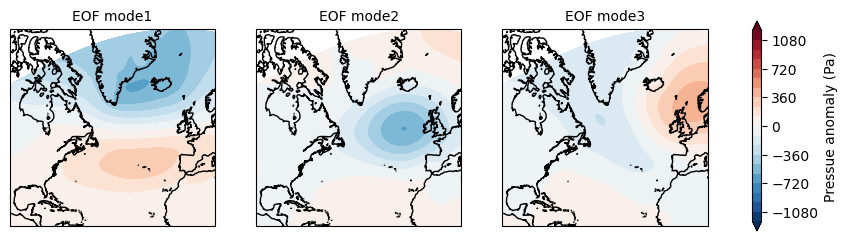

In [24]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_SLP[0], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_SLP[1], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_SLP[2], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressue anomaly (Pa)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

The first EOF mode becomes the NAO. Note that this is weaker than the DJF NAO, but the pattern is quite similar to wintertime NAO. We can also look at the reduced NAO pattern from the amplitude of the NAOi. Also note that the variance explained by the first EOF mode reduces from 42 to 37 percent as we go from DJF to all-season NAO.

In [25]:
print('Percentage of EOF explained by first ' + str(3) + ' modes:' + str(
    100 * np.round(solver_SLP.varianceFraction(neigs = 3).values, 4)))

Percentage of EOF explained by first 3 modes:[37.56     20.14     12.700001]


## Comparing the NAO index time series (computing by taking the first principal component) for DJF vs all months

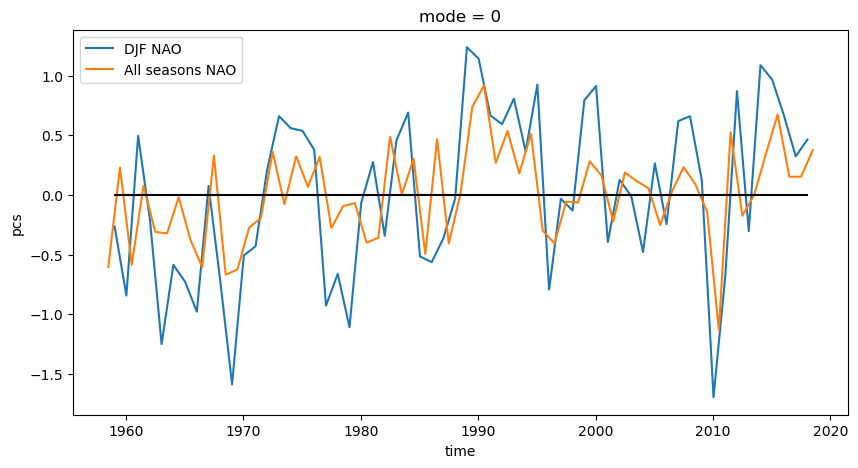

In [29]:
pcs_DJF_SLP = solver_DJF_SLP.pcs(npcs = npcs, pcscaling = 1).sel(time = slice('1958-12-01', '2018-02-28'))
pcs_SLP = solver_SLP.pcs(npcs = npcs, pcscaling = 1)

plt.figure(figsize = (10, 5))
pcs_DJF_SLP.sel(mode = 0).coarsen(time = 3).mean().plot(label = 'DJF NAO')
pcs_SLP.sel(mode = 0).coarsen(time = 12).mean().plot(label = 'All seasons NAO')
plt.plot(pcs_DJF_SLP.sel(mode = 0).coarsen(time = 3).mean().time, np.zeros(60), color = 'black')
plt.legend()

## Saving monthly data for all forcing variables

Next, we check how the following variables change with respect to the NAOi that we have calculated above:
1. `psl`: Sea level pressure
2. `tas`: Surface air temperature
3. `huss`: Specific humidity
4. `uas`: Zonal wind speed
5. `vas`: Meridional wind speed
6. `rlds`: Longwave radiation
7. `rsds`: Shortwave radiation
8. `lprec`: Liquid precipitation
9. `fprec`: Frozen precipitation
10. `friver`: Runoff
11. `licalvf`: Calving of icebergs

Interesting fact: The next four cells are optimised by ChatGPT (10 minutes for each cell compared to 4 hours before).

### For variables 1-5

In [5]:
dir_var = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0'
start_year, end_year = 1958, 2018

var = 'vas'
# Prepare file paths
file_paths = [
    f"{dir_var}/atmos/3hrPt/{var}/gr/v20190429/{var}_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_{year}01010000-{year}12312100.nc"
    for year in range(start_year, end_year + 1)
]

# Use open_mfdataset to open all the files at once, automatically concatenating along the 'time' dimension
var_total = xr.open_mfdataset(file_paths, combine = 'by_coords', chunks = {'time': 'auto'})[var]

# Resample and compute the mean at monthly frequency
var_monthly_mean = var_total.resample(time='ME').mean()

var_monthly_mean.rename(var).to_dataset().to_netcdf(
    path = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_data/' + var + '_raw.nc',
    mode = 'w', format = "NETCDF4", engine = "netcdf4")

### For variables 6-9

In [10]:
dir_var = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0'
start_year, end_year = 1958, 2018

var = 'rlds'
# Prepare file paths
file_paths = [
    f"{dir_var}/atmos/3hr/{var}/gr/v20190429/{var}_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_{year}01010130-{year}12312230.nc"
    for year in range(start_year, end_year + 1)
]

# Use open_mfdataset to open all the files at once, automatically concatenating along the 'time' dimension
var_total = xr.open_mfdataset(file_paths, combine = 'by_coords', chunks = {'time': 'auto'})[var]

# Resample and compute the mean at monthly frequency
var_monthly_mean = var_total.resample(time='ME').mean()

var_monthly_mean.rename(var).to_dataset().to_netcdf(
    path = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_data/' + var + '_raw.nc',
    mode = 'w', format = "NETCDF4", engine = "netcdf4")

### For variable 10

In [9]:
dir_var = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0'
start_year, end_year = 1958, 2018

var = 'friver'
# Prepare file paths
file_paths = [
    f"{dir_var}/land/day/{var}/gr/v20190429/{var}_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_{year}0101-{year}1231.nc"
    for year in range(start_year, end_year + 1)
]

# Use open_mfdataset to open all the files at once, automatically concatenating along the 'time' dimension
var_total = xr.open_mfdataset(file_paths, combine = 'by_coords', chunks = {'time': 'auto'})[var]

# Resample and compute the mean at monthly frequency
var_monthly_mean = var_total.resample(time='ME').mean()

var_monthly_mean.rename(var).to_dataset().to_netcdf(
    path = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_data/' + var + '_raw.nc',
    mode = 'w', format = "NETCDF4", engine = "netcdf4")

### For variable 11

In [11]:
dir_var = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0'
start_year, end_year = 1958, 2018

var = 'licalvf'
# Prepare file paths
file_paths = [
    f"{dir_var}/landIce/day/{var}/gr/v20190429/{var}_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_{year}0101-{year}1231.nc"
    for year in range(start_year, end_year + 1)
]

# Use open_mfdataset to open all the files at once, automatically concatenating along the 'time' dimension
var_total = xr.open_mfdataset(file_paths, combine = 'by_coords', chunks = {'time': 'auto'})[var]

# Resample and compute the mean at monthly frequency
var_monthly_mean = var_total.resample(time='ME').mean()

var_monthly_mean.rename(var).to_dataset().to_netcdf(
    path = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_data/' + var + '_raw.nc',
    mode = 'w', format = "NETCDF4", engine = "netcdf4")

## Correlation and regression for all forcing variables

In [26]:
## Take the first principal component (normalised)
NAO_index = solver_SLP.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0)

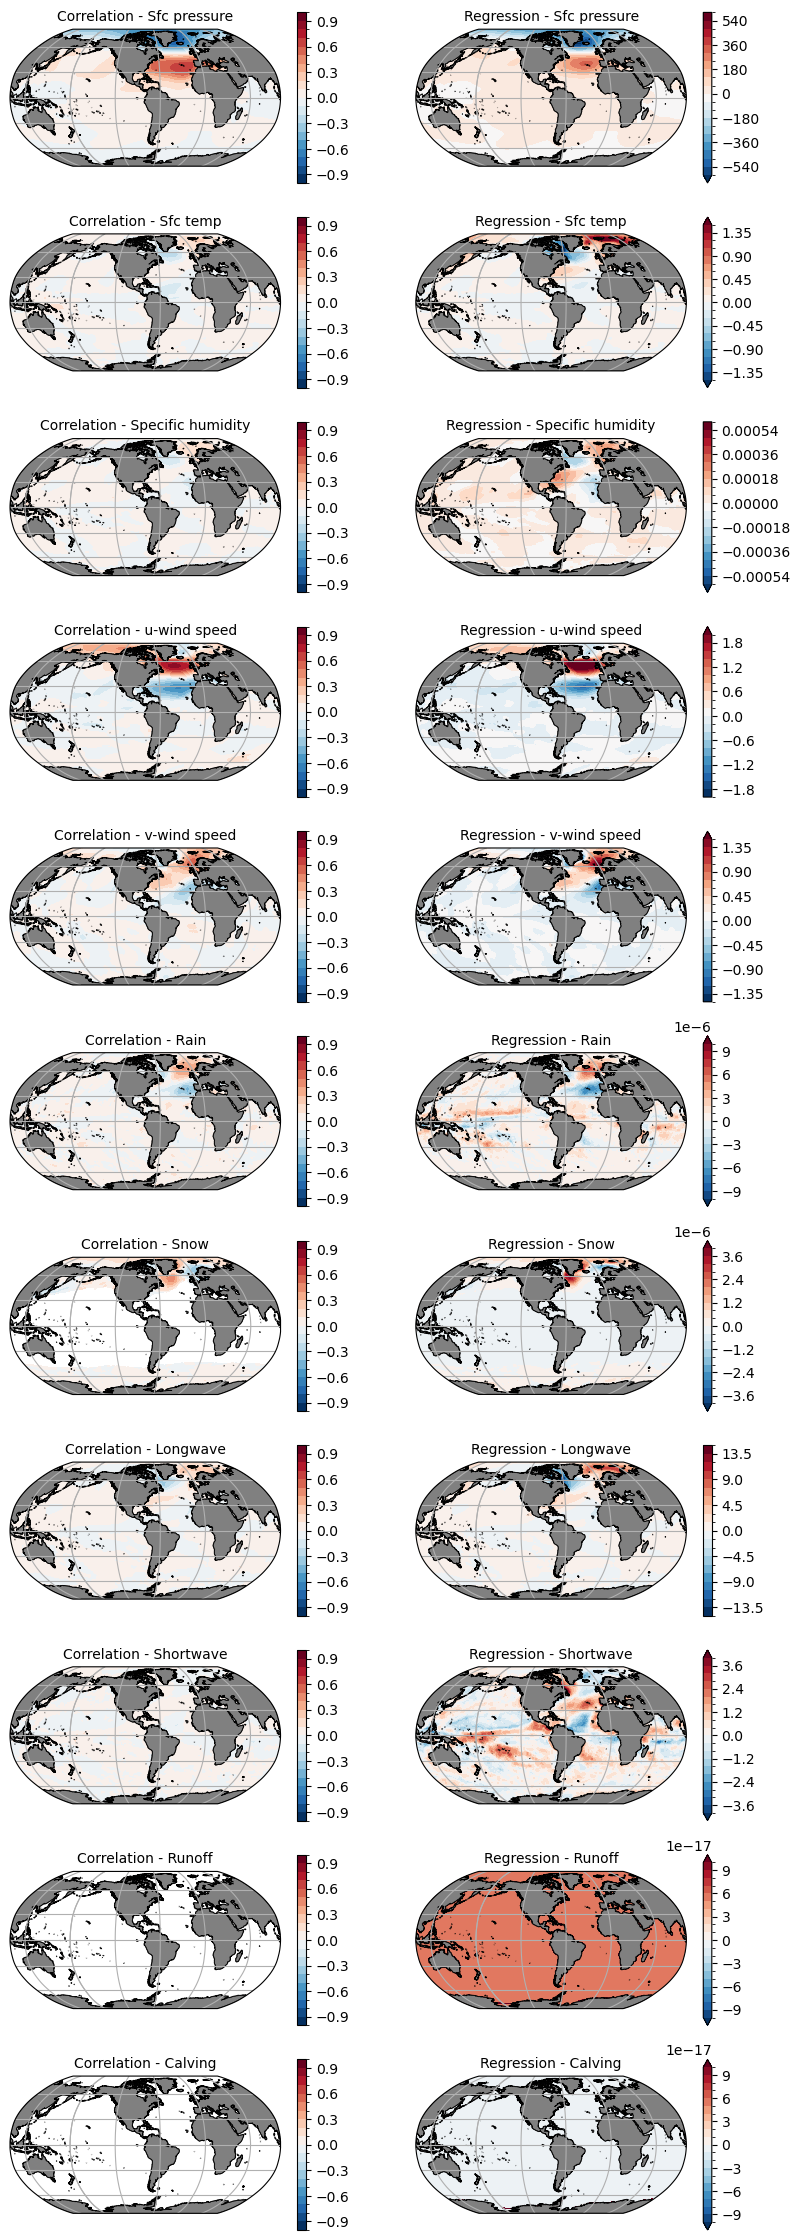

In [30]:
fig = plt.figure()
fig.set_figheight(24 * 1.2)
fig.set_figwidth(8 * 1.2)

var_series = ['psl', 'tas', 'huss', 'uas', 'vas', 'prra', 'prsn', 'rlds', 'rsds', 'friver', 'licalvf']
limits     = [600,   1.5,   6e-4,   2,     1.5,   1e-5,   4e-6,   15,     4,       1e-16,       1e-16]
label_series = ['Sfc pressure', 'Sfc temp', 'Specific humidity', 'u-wind speed', 'v-wind speed', 'Rain', 'Snow', 'Longwave', 'Shortwave', 'Runoff', 'Calving']

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)

for i, j in enumerate(var_series):
    var_forcing_input = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_data/' + j + '_raw.nc')[j]

    b = var_forcing_input
    b['time'] = NAO_index.time

    correlation = xr.corr(NAO_index, b, 'time')
    regression = ((NAO_index - NAO_index.mean('time'))*(b - b.mean('time'))/NAO_index.std('time')).mean('time')


    ax1 = plt.subplot2grid(shape = (len(var_series), 2), loc = (i, 0), rowspan = 1, colspan = 1, projection = ccrs.Robinson(central_longitude = -80))
    ax1.coastlines(resolution = '50m')
    ax1.add_feature(land_50m)
    gl = ax1.gridlines(draw_labels = False)

    ax2 = plt.subplot2grid(shape = (len(var_series), 2), loc = (i, 1), rowspan = 1, colspan = 1, projection = ccrs.Robinson(central_longitude = -80))
    ax2.coastlines(resolution = '50m')
    ax2.add_feature(land_50m)
    gl = ax2.gridlines(draw_labels = False)

    p1 = correlation.plot.contourf(ax = ax1, x = 'lon', y = 'lat', cmap = 'RdBu_r', 
                                   transform = ccrs.PlateCarree(), levels = np.linspace(-1, 1, 21),
                                   add_colorbar = True, rasterized = True, zorder = -20)
    ax1.set_title('Correlation - ' + label_series[i], fontsize = 10)

    p2 = regression.plot.contourf(ax = ax2, x = 'lon', y = 'lat', cmap = 'RdBu_r', 
                                   transform = ccrs.PlateCarree(), levels = np.linspace(-limits[i], limits[i], 21),
                                   add_colorbar = True, rasterized = True, zorder = -20)
    ax2.set_title('Regression - ' + label_series[i], fontsize = 10)